In [1]:
import numpy as np
import pandas as pd

scoring_file = '../moda/3_EventLocations_exp_re.txt'
user_mapping_file = '../moda/5_userSubtypeAnonymLUT_exp_re.txt'

scoring_df = pd.read_csv(scoring_file, sep='\t')
user_mapping_df = pd.read_csv(user_mapping_file, sep='\t')

test_s_ids = [
    "01-05-0024", "01-05-0020", "01-04-0013", "01-03-0033", "01-03-0023", "01-04-0008", "01-04-0029", "01-05-0002",
    "01-04-0015", "01-04-0007", "01-03-0003", "01-02-0006", "01-05-0018", "01-03-0059", "01-03-0040", "01-03-0004",
    "01-04-0016", "01-02-0010", "01-03-0060", "01-03-0026", "01-01-0023", "01-03-0062", "01-01-0046", "01-01-0048",
    "01-03-0051", "01-03-0012", "01-01-0044", "01-03-0064", "01-01-0043", "01-01-0029", "01-03-0027", "01-01-0028",
    "01-03-0031", "01-03-0014", "01-01-0049", "01-01-0004"
]

# shared functions

In [2]:
def calc_tp_fp_fn(gt_spindles, pred_spindles, spindle_thresholds):
    # make sure spindles are sorted
    gt_spindles = gt_spindles[np.argsort(gt_spindles[:, 0])]
    pred_spindles = pred_spindles[np.argsort(pred_spindles[:, 0])]
    tp, fp = [0] * len(spindle_thresholds), [0] * len(spindle_thresholds)

    used_spindles = [np.zeros(len(gt_spindles)) for _ in range(len(spindle_thresholds))]
    gt_start = 0
    for pred_s in pred_spindles:
        intersects = [0] * len(gt_spindles)
        unions = [0] * len(gt_spindles)
        for gt_i in range(gt_start, len(gt_spindles)):
            gt_s = gt_spindles[gt_i]
            if pred_s[1] < gt_s[0]:
                break
            if pred_s[0] > gt_s[1]:
                gt_start = gt_i + 1
                continue
            intersects[gt_i] = min(gt_s[1], pred_s[1]) - max(gt_s[0], pred_s[0])
            unions[gt_i] = max(gt_s[1], pred_s[1]) - min(gt_s[0], pred_s[0])
        ious = [intersects[i] / unions[i] if unions[i] > 0 else 0
                for i in range(len(intersects))]
        for i, spindle_threshold in enumerate(spindle_thresholds):
            if len(ious) > 0 and max(ious) > spindle_threshold:
                tp[i] += 1
                used_spindles[i][np.argmax(ious)] = 1
            else:
                fp[i] += 1

    fn = [len(gt_spindles) - np.sum(used_spindles[i]) for i in range(len(spindle_thresholds))]

    return tp, fp, fn


def onehot_to_spindles(spindles_onehot):
    diff = np.diff(spindles_onehot, prepend=0, append=0)
    start = np.where(diff == 1)[0] / 100
    end = np.where(diff == -1)[0] / 100
    return np.vstack([start, end]).T


def spindles_to_onehot(spindles, length=11500):
    onehot = np.zeros(length)
    for start, end in spindles:
        onehot[int(start * 100):int(end * 100)] = 1
    return onehot


def merge_and_filter_spindles(spindles, merge_dur=0.3, merge_dist=0.1, min_dur=0.3, max_dur=2.5):
    sort_idx = np.argsort(spindles[:, 0])
    spindles = spindles[sort_idx]
    durations = spindles[:, 1] - spindles[:, 0]
    distances = spindles[1:, 0] - spindles[:-1, 1]
    to_merge = (durations[:-1] < merge_dur) & (durations[1:] < merge_dur) & (distances < merge_dist)
    spindles[np.r_[to_merge, False], 1] = spindles[np.r_[False, to_merge], 1]
    spindles = spindles[~np.r_[False, to_merge]]

    durations = spindles[:, 1] - spindles[:, 0]
    to_filter = (durations < min_dur) | (durations > max_dur)
    spindles = spindles[~to_filter]

    print(f'Merged {np.sum(to_merge)} spindles, filtered {np.sum(to_filter)} spindles')

    return spindles

# load spindles

In [3]:
expert_descr = 'psgTech'
expert_ids = user_mapping_df.query(f"userSubType == '{expert_descr}'")['userName'].values
expert_ids.sort()

In [4]:
expert_scoring_df = scoring_df[scoring_df['annotatorID'].isin(expert_ids)]
# remove unnecessary columns
expert_scoring_df = expert_scoring_df[
    ['phase', 'subID', 'annotatorID', 'blockNum', 'epochNum', 'startSecs', 'durationSecs', 'scoreConfidence']]
# remove rows with NaN values
expert_scoring_df = expert_scoring_df.dropna(subset=['startSecs', 'durationSecs'])
# expert_scoring_df = expert_scoring_df.dropna()
# remove rows with too high epochNums, maximum: 2025 + 1721 + 4 = 3750
expert_scoring_df = expert_scoring_df.query('epochNum <= 3750')
# set minimum startSec to 0
expert_scoring_df['startSecs'] = expert_scoring_df['startSecs'].clip(lower=0)
expert_scoring_df['startSecs'] = expert_scoring_df['startSecs'].round(2)
expert_scoring_df['durationSecs'] = expert_scoring_df['durationSecs'].round(2)
expert_scoring_df['endSecs'] = expert_scoring_df['startSecs'] + expert_scoring_df['durationSecs']

In [5]:
# rereference start time of spindles to block start
start_epochs_per_block_df_p1 = pd.read_csv('../moda/6_segListSrcDataLoc_p1.txt', sep='\t')[
    ['epochNum', 'blockNumExp', 'subjectID']]
start_epochs_per_block_df_p2 = pd.read_csv('../moda/7_segListSrcDataLoc_p2.txt', sep='\t')[
    ['epochNum', 'blockNumExp', 'subjectID']]
start_epochs_per_block_df_p2['epochNum'] += start_epochs_per_block_df_p1['epochNum'].max() + 4
start_epochs_per_block_df = pd.concat([start_epochs_per_block_df_p1, start_epochs_per_block_df_p2])

epoch_nums = expert_scoring_df['epochNum'].values
block_nums = expert_scoring_df['blockNum'].values
s_ids = expert_scoring_df['subID'].values

seg_subject_ids = start_epochs_per_block_df['subjectID'].values
seg_block_nums = start_epochs_per_block_df['blockNumExp'].values
seg_epoch_nums = start_epochs_per_block_df['epochNum'].values

matches = (s_ids[:, None] == seg_subject_ids) & (block_nums[:, None] == seg_block_nums)

match_indices = np.argmax(matches, axis=1)
has_match = matches[np.arange(matches.shape[0]), match_indices]
block_start_epochs = np.where(has_match, seg_epoch_nums[match_indices], np.nan)

expert_scoring_df.loc[has_match, 'startSecs'] += (epoch_nums[has_match] - block_start_epochs[has_match]) * 22.5
expert_scoring_df.loc[has_match, 'endSecs'] = expert_scoring_df.loc[has_match, 'startSecs'] + expert_scoring_df.loc[
    has_match, 'durationSecs']

In [6]:
# remove duplicated overlapping spindles
# (spindles that were annotated in the overlap between two epochs in both blocks)
expert_scoring_no_overlap_entries = []
for g_idx, g_df in expert_scoring_df.groupby(['subID', 'annotatorID', 'blockNum']):
    spindles = g_df[['startSecs', 'endSecs']].values
    spindles_onehot = spindles_to_onehot(spindles)
    spindles_no_overlap = onehot_to_spindles(spindles_onehot)
    base_row = g_df.iloc[0]
    expert_scoring_no_overlap_entries.extend([
        (base_row['phase'], base_row['subID'], base_row['annotatorID'], base_row['blockNum'],
         base_row['epochNum'] + int(start / 22.5), start, end, 'TODO')
        for start, end in spindles_no_overlap])

expert_scoring_no_overlap_df = pd.DataFrame(expert_scoring_no_overlap_entries,
                                            columns=['phase', 'subID', 'annotatorID', 'blockNum', 'epochNum',
                                                     'startSecs', 'endSecs', 'scoreConfidence'])

In [7]:
# also look at epochs without annotations
epoch_views_file = '../moda/1_EpochViews_exp_re.txt'
epoch_views_df = pd.read_csv(epoch_views_file, sep='\t')
expert_epoch_views_df = epoch_views_df[epoch_views_df['annotatorID'].isin(expert_ids)].copy()
expert_epoch_views_df['subID'] = expert_epoch_views_df['filename'].str.extract(r'(\d{2}-\d{2}-\d{4})')
# remove "phase 3"
expert_epoch_views_df = expert_epoch_views_df.query('epochNum <= 3750')

In [8]:
pred_path = '../../output/annotations/moda/all_aggregated.npz'
pred_data = np.load(pred_path)

pred_sp_entries = []
for key in pred_data.keys():
    s_id = key.split('_')[0]
    pred_sp_entries.extend([(s_id, *r) for r in pred_data[key]])
pred_sp_df = pd.DataFrame(pred_sp_entries,
                          columns=['patient_id', 'block_num', 'start', 'end', 'frequency', 'amplitude_ptp',
                                   'amplitude_hilbert'])
pred_sp_df['block_num'] += 1
pred_sp_df

,patient_id,block_num,start,end,frequency,amplitude_ptp,amplitude_hilbert
0,01-05-0018,1.0,2.47,2.96,14.423077,3.555003,0.633983
1,01-05-0018,1.0,13.96,14.75,13.596491,2.861188,0.469100
2,01-05-0018,1.0,20.27,21.71,12.642857,4.435452,0.808233
3,01-05-0018,1.0,26.39,27.13,12.685185,2.450578,0.617122
4,01-05-0018,1.0,30.09,30.82,13.088235,3.505278,0.625094
...,...,...,...,...,...,...,...
713,01-03-0064,2.0,33.75,34.19,13.083333,2.802256,0.676173
714,01-03-0064,2.0,37.05,38.15,12.962963,4.136710,0.739469
715,01-03-0064,2.0,69.83,70.52,13.281250,2.493570,0.642324
716,01-03-0064,2.0,82.28,82.85,13.269231,3.056939,0.564403


# compare predicted spindles to expert spindles

In [9]:
overlap_thresholds = np.linspace(0, 1, 21)

metrics_df_rows = []
for g_idx, g_df in expert_epoch_views_df.groupby(['subID', 'blockNum', 'annotatorID']):
    if g_idx[0] not in test_s_ids:
        continue
    phase = g_df['phase'].iloc[0]
    sub_id, block_num, expert_id = g_idx

    expert_spindles = expert_scoring_no_overlap_df.query(
        f'subID == "{sub_id}" and annotatorID == {expert_id} and blockNum == {block_num}'
    )[['startSecs', 'endSecs']].values
    pred_spindles = pred_sp_df.query(f'patient_id == "{sub_id}" and block_num == {block_num}')[['start', 'end']].values
    if len(pred_spindles) > 0:
        pred_spindles = merge_and_filter_spindles(pred_spindles)

    tp, fp, fn = calc_tp_fp_fn(expert_spindles, pred_spindles, overlap_thresholds)
    metrics_df_rows.append(
        {'phase': phase, 'subID': sub_id, 'annotatorID': expert_id,
         'blockNum': block_num, 'TP': tp, 'FP': fp, 'FN': fn})

metrics_block_df = pd.DataFrame(metrics_df_rows)
metrics_block_df

Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filtered 0 spindles
Merged 0 spindles, filter

,phase,subID,annotatorID,blockNum,TP,FP,FN
0,phase2,01-01-0004,8,1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, ..."
1,phase2,01-01-0004,47,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2,phase2,01-01-0004,54,1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ..."
3,phase2,01-01-0004,58,1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,phase2,01-01-0004,12,2,"[3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, ...","[3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ..."
...,...,...,...,...,...,...,...
529,phase1,01-05-0024,0,3,"[9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 7, 7, 7, 6, 6, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 2, 3, 3, ...","[3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0, ..."
530,phase1,01-05-0024,12,3,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, ...","[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
531,phase1,01-05-0024,25,3,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, ...","[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
532,phase1,01-05-0024,37,3,"[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 5, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 4, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [10]:
metrics_expert_entries = []
for ann_id, g_df in metrics_block_df.groupby(['annotatorID']):
    tp = np.concatenate(g_df['TP'].values)[:, None].reshape(-1, len(overlap_thresholds)).sum(axis=0)
    fp = np.concatenate(g_df['FP'].values)[:, None].reshape(-1, len(overlap_thresholds)).sum(axis=0)
    fn = np.concatenate(g_df['FN'].values)[:, None].reshape(-1, len(overlap_thresholds)).sum(axis=0)
    precision = [tp_i / (tp_i + fp_i) if tp_i + fp_i > 0 else 1 for tp_i, fp_i in zip(tp, fp)]
    recall = [tp_i / (tp_i + fn_i) if tp_i + fn_i > 0 else 1 for tp_i, fn_i in zip(tp, fn)]
    f1 = [2 * p * r / (p + r) if p + r > 0 else 0 for p, r in zip(precision, recall)]
    metrics_expert_entries.append(
        {'phase': g_df['phase'].iloc[0], 'annotatorID': ann_id, 'n_blocks': g_df.groupby(['subID', 'blockNum']).ngroups,
         'TP': tp, 'FP': fp, 'FN': fn, 'precision': precision, 'recall': recall, 'f1': f1})

metrics_expert_df = pd.DataFrame(metrics_expert_entries)
metrics_expert_df

,phase,annotatorID,n_blocks,TP,FP,FN,precision,recall,f1
0,phase2,"(0,)",51,"[368, 368, 368, 368, 368, 367, 367, 364, 355, ...","[10, 10, 10, 10, 10, 11, 11, 14, 23, 27, 41, 5...","[633.0, 633.0, 633.0, 633.0, 633.0, 634.0, 634...","[0.9735449735449735, 0.9735449735449735, 0.973...","[0.3676323676323676, 0.3676323676323676, 0.367...","[0.5337200870195793, 0.5337200870195793, 0.533..."
1,phase1,"(2,)",14,"[85, 85, 85, 85, 85, 83, 83, 82, 80, 78, 74, 6...","[14, 14, 14, 14, 14, 16, 16, 17, 19, 21, 25, 3...","[46.0, 46.0, 46.0, 46.0, 46.0, 48.0, 48.0, 49....","[0.8585858585858586, 0.8585858585858586, 0.858...","[0.648854961832061, 0.648854961832061, 0.64885...","[0.7391304347826086, 0.7391304347826086, 0.739..."
2,phase2,"(6,)",5,"[25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 2...","[27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 2...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.4807692307692308, 0.4807692307692308, 0.480...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.6493506493506493, 0.6493506493506493, 0.649..."
3,phase2,"(8,)",3,"[11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 10, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 3, 4, ...","[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, ...","[0.9166666666666666, 0.9166666666666666, 0.916...","[0.5789473684210527, 0.5789473684210527, 0.578...","[0.7096774193548387, 0.7096774193548387, 0.709..."
4,phase2,"(9,)",3,"[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 5, 4, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 4, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.8...","[0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.8...","[0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.8..."
5,phase2,"(10,)",8,"[33, 33, 33, 33, 33, 33, 33, 33, 32, 32, 30, 3...","[9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 12, 12, 13, 1...","[4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 5.0, ...","[0.7857142857142857, 0.7857142857142857, 0.785...","[0.8918918918918919, 0.8918918918918919, 0.891...","[0.8354430379746834, 0.8354430379746834, 0.835..."
6,phase2,"(11,)",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,phase2,"(12,)",24,"[119, 119, 119, 119, 119, 119, 119, 116, 114, ...","[83, 83, 83, 83, 83, 83, 83, 86, 88, 89, 92, 9...","[22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 24....","[0.5891089108910891, 0.5891089108910891, 0.589...","[0.8439716312056738, 0.8439716312056738, 0.843...","[0.693877551020408, 0.693877551020408, 0.69387..."
8,phase1,"(13,)",2,"[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 1...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, ...","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[0.8571428571428571, 0.8571428571428571, 0.857...","[0.8571428571428571, 0.8571428571428571, 0.857...","[0.8571428571428571, 0.8571428571428571, 0.857..."
9,phase2,"(17,)",15,"[79, 79, 79, 79, 79, 78, 76, 70, 65, 62, 57, 5...","[3, 3, 3, 3, 3, 4, 6, 12, 17, 20, 25, 31, 42, ...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 102...","[0.9634146341463414, 0.9634146341463414, 0.963...","[0.441340782122905, 0.441340782122905, 0.44134...","[0.6053639846743295, 0.6053639846743295, 0.605..."


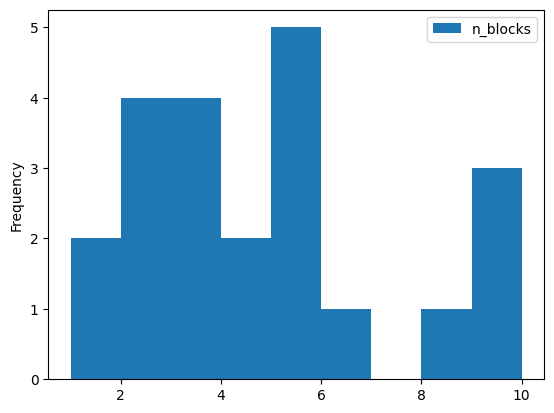

In [11]:
metrics_expert_df.plot.hist(y='n_blocks', bins=range(1, 11))
metrics_expert_df = metrics_expert_df.query('n_blocks >= 5')

In [12]:
f1s = np.concatenate(metrics_expert_df['f1'].values)[:, None].reshape(-1, len(overlap_thresholds))[:, 4]
precisions = np.concatenate(metrics_expert_df['precision'].values)[:, None].reshape(-1, len(overlap_thresholds))[:, 4]
recalls = np.concatenate(metrics_expert_df['recall'].values)[:, None].reshape(-1, len(overlap_thresholds))[:, 4]
n_subjects_compared = metrics_expert_df['n_blocks'].values
f1s

array([0.53372009, 0.73913043, 0.64935065, 0.83544304, 0.69387755,
       0.60536398, 0.62745098, 0.6519337 , 0.76086957, 0.75449102,
       0.75229358, 0.79646018, 0.8       , 0.76277372, 0.85393258,
       0.61269841, 0.75789474, 0.78125   , 0.8137931 , 0.81538462,
       0.76681614, 0.63247863, 0.64      , 0.68199234, 0.73015873,
       0.70588235, 0.64835165, 0.61716937, 0.79411765])

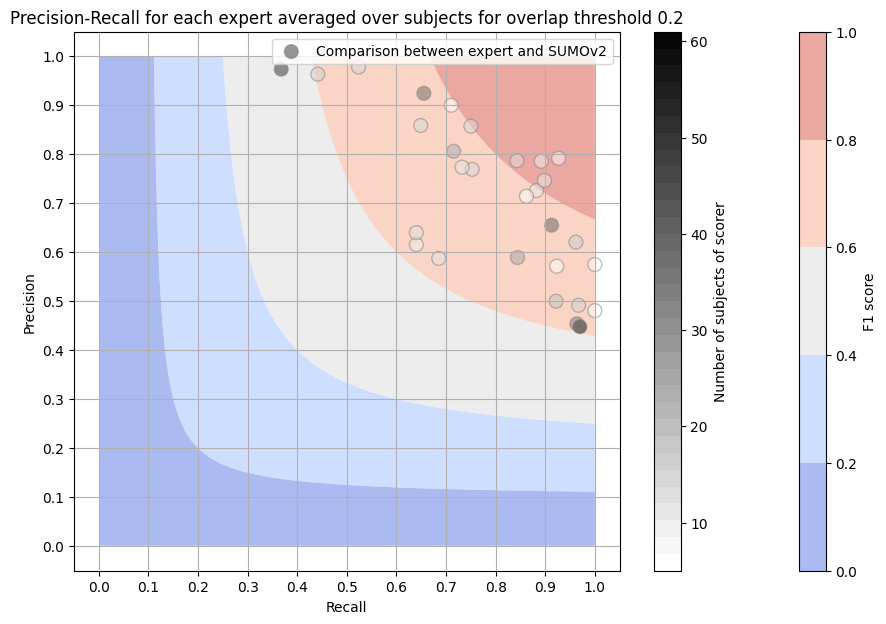

In [14]:
from matplotlib import pyplot as plt
import matplotlib as mpl

plt.figure(figsize=(11, 7))
color_scale = [
    255 - 255 / (np.max(n_subjects_compared) - np.min(n_subjects_compared)) * (n_epochs - np.min(n_subjects_compared))
    for n_epochs in n_subjects_compared]
colors = [f'#{int(c):02x}{int(c):02x}{int(c):02x}' for c in color_scale]
my_cmap = mpl.colors.ListedColormap([f'#{int(c):02x}{int(c):02x}{int(c):02x}' for c in range(255, -1, -8)])
plt.scatter(recalls, precisions, c=colors, edgecolors="grey", s=100, alpha=0.5,
            label='Comparison between expert and SUMOv2')

r_mesh, p_mesh = np.meshgrid(np.linspace(1e-3, 1, 100), np.linspace(1e-3, 1, 100))
f1_mesh = 2 * p_mesh * r_mesh / (p_mesh + r_mesh)
plt.contourf(r_mesh, p_mesh, f1_mesh, levels=np.linspace(0, 1, 6), alpha=0.5, cmap='coolwarm', zorder=0,
             antialiased=True)
plt.colorbar(label='F1 score')

plt.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(np.min(n_subjects_compared), np.max(n_subjects_compared)),
                          cmap=my_cmap),
    ax=plt.gca(), orientation='vertical', label='Number of subjects of scorer')
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall for each expert averaged over subjects for overlap threshold {overlap_thresholds[4]:.1f}')
plt.grid()
plt.legend()
plt.show()